In [1]:
%load_ext autoreload
%autoreload 2

# Explaining why so many circuits have a sensitivity of 0.000333

In [2]:
import numpy as np
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from common import set_theme

PALETTE = 'viridis'
set_theme()

top_write_dir = os.path.join('data', '26_sensitivity_peak2')

In [3]:
fn_dataset1 = '../data/raw/summarise_simulation/2024_11_27_145142/tabulated_mutation_info.csv'
df1 = pd.read_csv(fn_dataset1)

In [4]:
dir_sim = os.path.join('..', 'notebooks', 'data', 'simulate_circuits', '2025_09_23__15_41_51')

fn_analytics = os.path.join(dir_sim, 'analytics.json')
with open(fn_analytics, 'r') as f:
    analytics = json.load(f)
    
fn_circuits = '../data/raw/generate_sequence_batch/2025_09_20_103744/circuits/rc.json'
fn_energies = '../data/raw/generate_sequence_batch/2025_09_20_103744/energies.json'

with open(fn_circuits, 'r') as f:
    circuits = json.load(f)
with open(fn_energies, 'r') as f:
    energies = json.load(f)
    
cols_e = [f'$RNA_{i+1}$-$RNA_{j+1}$' for i, j in zip(*np.triu_indices(3))]
energy_keys = sorted(energies.keys(), key=lambda k: int(k.split('_')[1]))


In [5]:
analytics = {k: np.array(v) for k, v in analytics.items()}

In [6]:
df2 = pd.DataFrame()
for i, spec in zip([-3, -2, -1], [f'$RNA_1$', f'$RNA_2$', f'$RNA_3$']):
    df_curr = pd.DataFrame({k: v[:, i] for k, v in analytics.items()})
    df_curr['Sample name'] = spec
    df_curr['circuit_idx'] = np.arange(len(df_curr))
    df2 = pd.concat([df2, df_curr])
df2['Log sensitivity'] = np.log10(df2['sensitivity'])
df2['Log precision'] = np.log10(df2['precision'])

In [7]:
df1['Is at peak'] = df1['sensitivity'] == df1[df1['sample_name'] == 'RNA_2']['sensitivity'].value_counts().reset_index().iloc[0]['sensitivity']
df2['Is at peak'] = df2['sensitivity'] == df2[df2['Sample name'] == f'$RNA_3$']['sensitivity'].value_counts().reset_index().iloc[0]['sensitivity']

In [ ]:
max_amount = df1[df1['sample_name'] != 'RNA_0']['max_amount'].value_counts().index[0]
steady_state = df1[df1['sample_name'] != 'RNA_0']['steady_states'].value_counts().index[0]
initial_steady_state = df1[df1['sample_name'] != 'RNA_0']['initial_steady_states'].value_counts().index[0]
steady_state_sig = df1[df1['sample_name'] == 'RNA_0']['steady_states'].value_counts().index[0]
initial_steady_state_sig = df1[df1['sample_name'] == 'RNA_0']['initial_steady_states'].value_counts().index[0]

sensitivity = np.abs(np.divide(
    (steady_state - initial_steady_state) / initial_steady_state,
    (steady_state_sig - initial_steady_state_sig) / initial_steady_state_sig
))
sensitivity

In [31]:
max_amount2 = df2[df2['Sample name'] != f'$RNA_1$']['max_amount'].value_counts().index[0]
steady_state2 = df2[df2['Sample name'] != f'$RNA_1$']['steady_states'].value_counts().index[0]
initial_steady_state2 = df2[df2['Sample name'] != f'$RNA_1$']['initial_steady_states'].value_counts().index[0]
steady_state_sig2 = df2[df2['Sample name'] == f'$RNA_1$']['steady_states'].value_counts().index[0]
initial_steady_state_sig2 = df2[df2['Sample name'] == f'$RNA_1$']['initial_steady_states'].value_counts().index[0]

sensitivity2 = np.abs(np.divide(
    (steady_state2 - initial_steady_state2) / initial_steady_state2,
    (steady_state_sig2 - initial_steady_state_sig2) / initial_steady_state_sig2
))
sensitivity2

np.float64(0.24957088911774805)

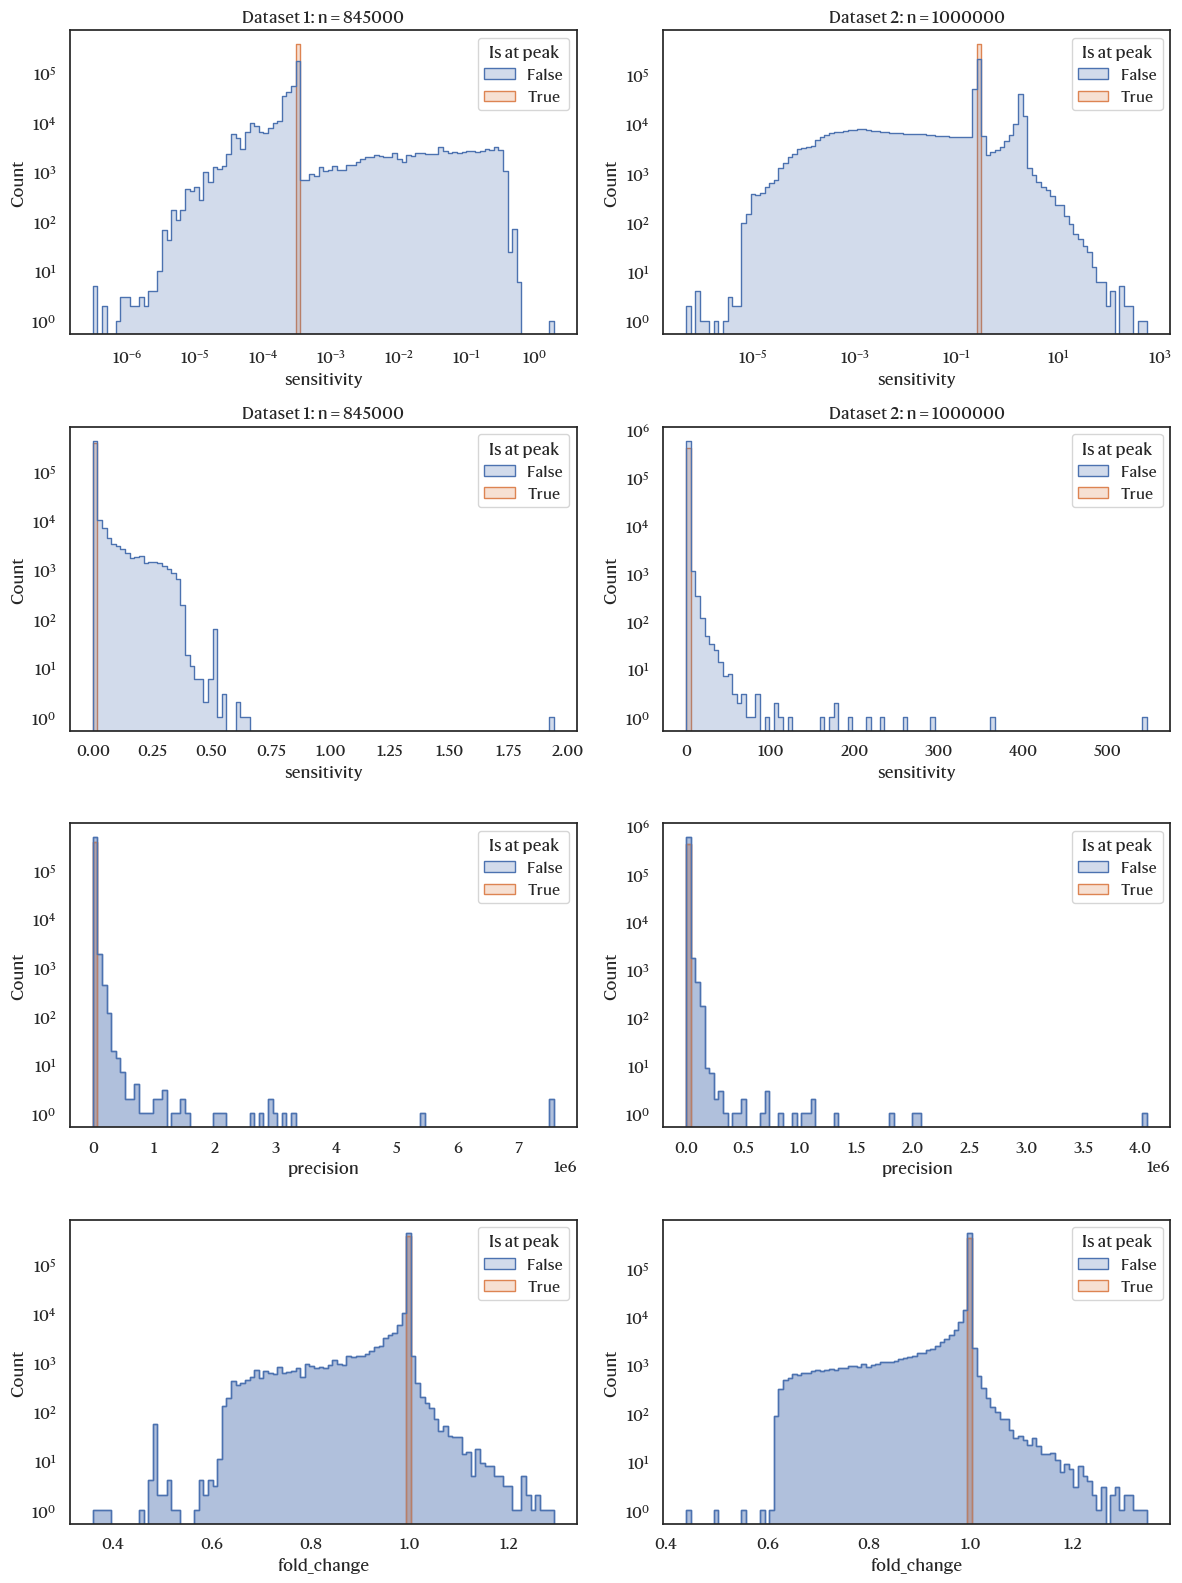

In [12]:
fig, axs = plt.subplots(4, 2, figsize=(6*2, 4*4))

for i, use_log in enumerate((True, False)):
    filt1 = (df1['sample_name'] == 'RNA_2')  # & (df1['mutation_num'] == 0)
    sns.histplot(df1[filt1], x='sensitivity', hue='Is at peak',
                 element='step', bins=100, log_scale=(use_log, False), ax=axs[i, 0])
    # sns.histplot(df1[filt1 & df1['Is at peak']], x='sensitivity',
    #             element='step', bins=100, log_scale=(True, False), ax=axs[i, 0], alpha=1)
    axs[i, 0].set_yscale('log')
    axs[i, 0].set_title(f'Dataset 1: n = {len(df1[filt1])}')
    filt2 = df2['Sample name'] == f'$RNA_3$'
    sns.histplot(df2[filt2], x='sensitivity', hue='Is at peak',
                 element='step', bins=100, log_scale=(use_log, False), ax=axs[i, 1])
    # sns.histplot(df2[filt2 & df2['Is at peak']], x='sensitivity',
    #             element='step', bins=100, log_scale=(True, False), ax=axs[i, 1], alpha=1)
    axs[i, 1].set_yscale('log')
    axs[i, 1].set_title(f'Dataset 2: n = {len(df2[filt2])}')

    for i, col in zip([2, 3], ['precision', 'fold_change']):
        sns.histplot(df1[filt1], x=col, hue='Is at peak',
                     element='step', bins=100, ax=axs[i, 0])
        axs[i, 0].set_yscale('log')
        sns.histplot(df2[filt2], x=col, hue='Is at peak',
                     element='step', bins=100, ax=axs[i, 1])
        axs[i, 1].set_yscale('log')
plt.tight_layout()

Text(0.5, 1.0, 'Dataset 2')

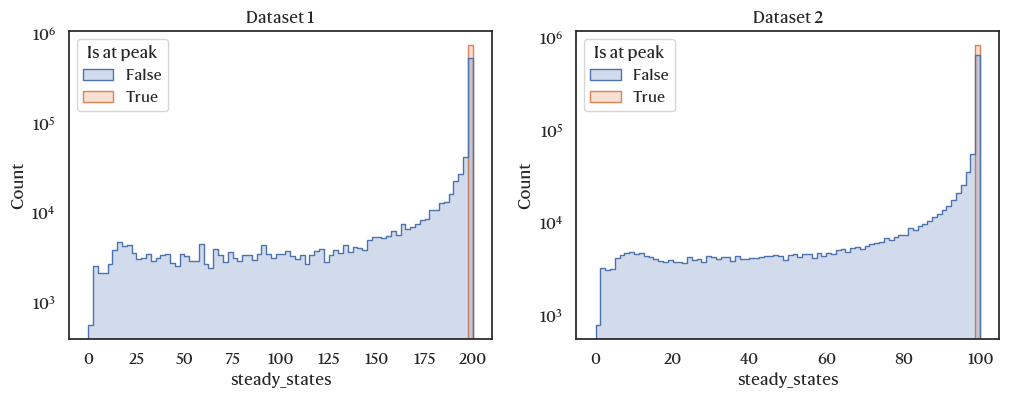

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(6*2, 4))
sns.histplot(df1[df1['sample_name'] != 'RNA_0'], x='steady_states', 
             hue='Is at peak', element='step', bins=80, ax=axs[0])
            #  hue='sample_name', element='step', bins=80, ax=axs[0])
axs[0].set_yscale('log')
axs[0].set_title('Dataset 1')
sns.histplot(df2[df2['Sample name'] != f'$RNA_1$'], x='steady_states', 
             hue='Is at peak', element='step', bins=80, ax=axs[1])
            #  hue='Sample name', element='step', bins=80, ax=axs[1])
axs[1].set_yscale('log')
axs[1].set_title('Dataset 2')

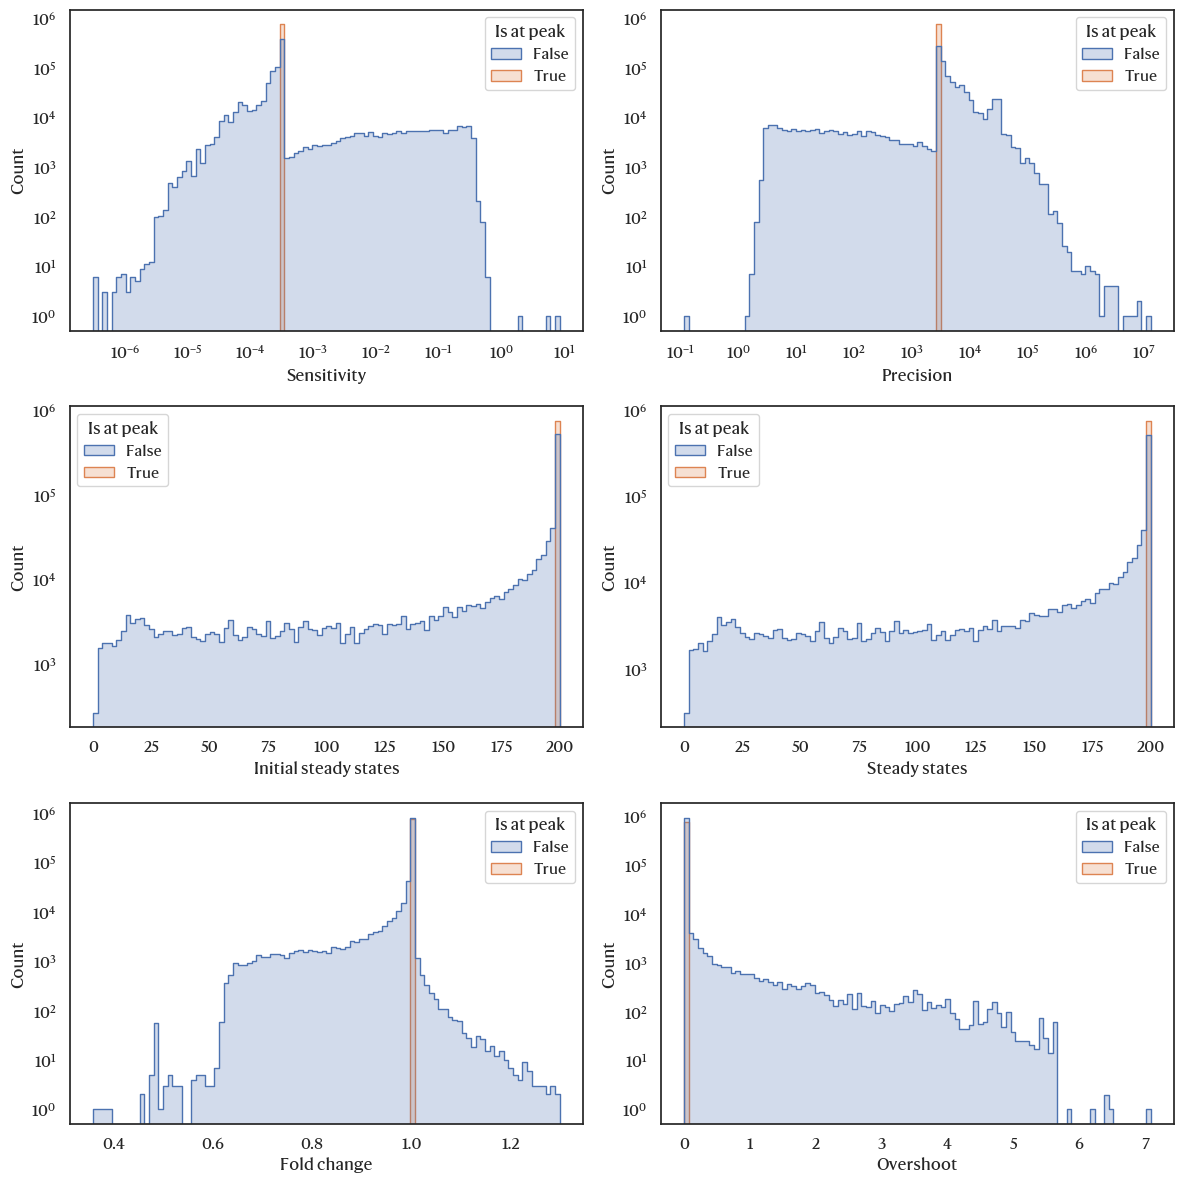

In [10]:
cols_plot = [
    'sensitivity', 'precision', 'initial_steady_states', 'steady_states', 'fold_change', 'overshoot']

nrows = 3
ncols = int(np.ceil(len(cols_plot) / nrows))
fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))

for ax, col in zip(axs.flat, cols_plot):
    sns.histplot(data=df1[df1['sample_name'] != 'RNA_0'], 
                 x=col, hue='Is at peak', 
                 bins=100, element='step', ax=ax,
                 log_scale=(True, False) if col in (
                     'sensitivity', 'precision') else (False, False))
    ax.set_yscale('log')
    ax.set_xlabel(col.replace('_', ' ').capitalize())
    # ax.set_title(col.replace('_', ' ').title())

plt.tight_layout()
